<a href="https://colab.research.google.com/github/khansaintania/2025_VISI_KOMPUTER_TI2B/blob/main/Implementasi%20R-CNN%2C%20Fast%20%20R-CNN%2C%20dan%20Faster%20R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementasi R-CNN, Fast R-CNN, dan Faster R-CNN

## Persiapan Environment

### Langkah 1: Aktifkan GPU di Google Colab

In [2]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

CUDA Available: True
CUDA Device: Tesla T4


### Langkah 2: Install Dependencies

In [3]:
# Install PyTorch dan torchvision
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install library pendukung
!pip install opencv-python matplotlib pillow numpy
!pip install pycocotools  # Untuk evaluasi dengan COCO metrics

# Install library untuk selective search (R-CNN dan Fast R-CNN)
!pip install selectivesearch

# Verify installation
import torch
import torchvision
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"OpenCV Version: {cv2.__version__}")


Looking in indexes: https://download.pytorch.org/whl/cu118
  Preparing metadata (setup.py) ... done
  Created wheel for selectivesearch: filename=selectivesearch-0.4-py3-none-any.whl size=4336 sha256=ff8f625aded4bf7d4e340f986b2c6043bb0cff673465151d4ab15ad2ce8466ce
  Stored in directory: /root/.cache/pip/wheels/7f/9b/c7/58b71f1e9fe4aa0ef8affd1c673f8818bc22a5091ea8cbbe93
Successfully built selectivesearch
PyTorch Version: 2.8.0+cu126
Torchvision Version: 0.23.0+cu126
OpenCV Version: 4.12.0


### Langkah 3: Download Dataset Sample

In [4]:
# Download dan extract dataset
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -q PennFudanPed.zip
!ls PennFudanPed/

--2025-11-21 01:13:26--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  29.3MB/s    in 1.7s    

2025-11-21 01:13:28 (29.3 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

added-object-list.txt  Annotation  PedMasks  PNGImages	readme.txt


### Langkah 4: Import Library Utama

In [5]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Praktikum 1: Implementasi R-CNN

### Langkah 1.1: Implementasi Selective Search

/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Generated 342 region proposals


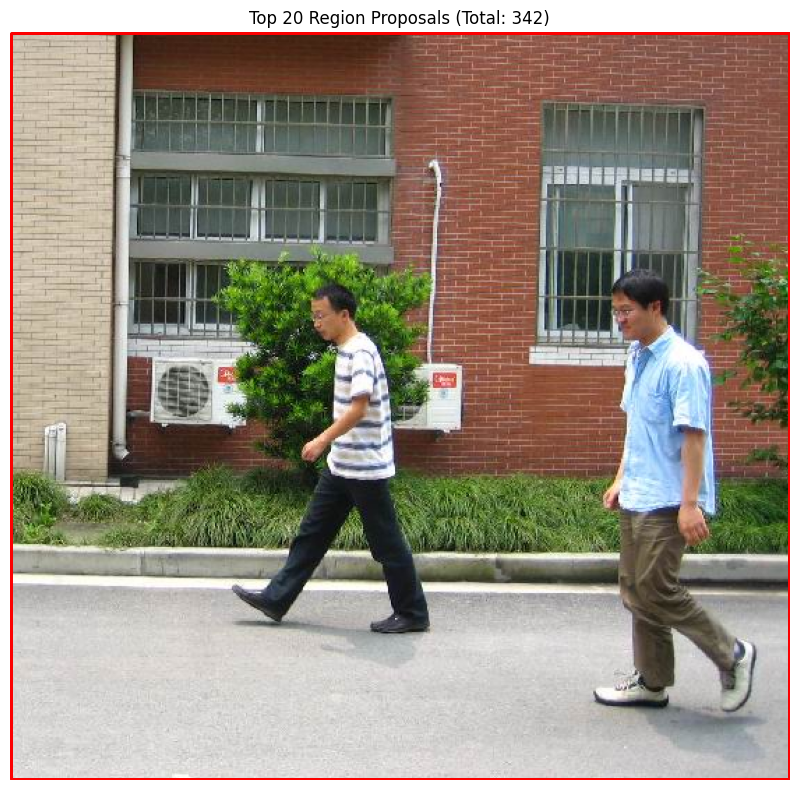

In [6]:
import selectivesearch

def generate_region_proposals(image_path, scale=500, sigma=0.9, min_size=10):
    """
    Generate region proposals using Selective Search

    Args:
        image_path: Path to input image
        scale: Larger scale -> fewer regions
        sigma: Width of Gaussian kernel for preprocessing
        min_size: Minimum component size

    Returns:
        regions: List of proposed regions with coordinates
    """

    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Run selective search
    img_lbl, regions = selectivesearch.selective_search(
        img_rgb,
        scale=scale,
        sigma=sigma,
        min_size=min_size
    )

    # Extract bounding boxes
    candidates = []
    for r in regions:
        # Exclude regions with size < 2000 pixels
        if r['size'] < 2000:
            continue

        # Get bounding box
        x, y, w, h = r['rect']

        # Exclude small regions
        if w < 20 or h < 20:
            continue

        candidates.append({
            'rect': (x, y, w, h),
            'size': r['size']
        })

    # Sort by size and take top 2000
    candidates = sorted(
        candidates,
        key=lambda x: x['size'],
        reverse=True
    )[:2000]

    return candidates, img_rgb


# Test selective search
image_path = 'PennFudanPed/PNGImages/FudanPed00001.png'
proposals, img = generate_region_proposals(image_path)
print(f"Generated {len(proposals)} region proposals")

# Visualize some proposals
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for i, prop in enumerate(proposals[:20]):  # Show first 20 proposals
    x, y, w, h = prop['rect']
    rect = patches.Rectangle(
        (x, y),
        w,
        h,
        linewidth=1,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

ax.set_title(
    f'Top 20 Region Proposals (Total: {len(proposals)})'
)
plt.axis('off')
plt.tight_layout()
plt.savefig('rcnn_proposals.png', dpi=150, bbox_inches='tight')
plt.show()


### Langkah 1.2: Feature Extraction dengan Pre-trained CNN

In [7]:
from torchvision.models import resnet50, ResNet50_Weights

class RCNNFeatureExtractor:
    """
    Feature extractor for R-CNN using pre-trained ResNet50
    """
    def __init__(self, device='cuda'):
        self.device = device

        # Load pre-trained ResNet50
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.model = resnet50(weights=weights)

        # Remove final classification layer
        self.model = nn.Sequential(*list(self.model.children())[:-1])
        self.model.to(device)
        self.model.eval()

        # Define transforms
        self.transform = weights.transforms()

    def extract_features(self, image, regions):
        """
        Extract features from regions

        Args:
            image: PIL Image or numpy array
            regions: List of region proposals

        Returns:
            features: Tensor of shape [N, 2048] where N is number of regions
            valid_regions: List of valid regions (some may be filtered)
        """
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        features_list = []
        valid_regions = []

        with torch.no_grad():
            for region in regions:
                x, y, w, h = region['rect']

                # Crop region
                try:
                    region_img = image.crop((x, y, x + w, y + h))

                    # Transform and add batch dimension
                    region_tensor = self.transform(region_img).unsqueeze(0).to(self.device)

                    # Extract features
                    features = self.model(region_tensor)
                    features = features.squeeze()

                    features_list.append(features.cpu())
                    valid_regions.append(region)
                except:
                    continue

        if len(features_list) == 0:
            return None, []

        features = torch.stack(features_list)
        return features, valid_regions


# Test feature extraction
extractor = RCNNFeatureExtractor(device=device)
features, valid_regions = extractor.extract_features(img, proposals[:100])

print(f"Extracted features shape: {features.shape}")
print(f"Valid regions: {len(valid_regions)}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


Extracted features shape: torch.Size([100, 2048])
Valid regions: 100


### Langkah 1.3: Classification dengan SVM

In [8]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

class RCNNClassifier:
    """
    SVM classifier for R-CNN
    """
    def __init__(self, num_classes=2):
        self.num_classes = num_classes
        self.scaler = StandardScaler()
        self.svm = SVC(kernel='linear', probability=True, random_state=42)

    def train(self, features, labels):
        """
        Train SVM classifier

        Args:
            features: numpy array of shape [N, feature_dim]
            labels: numpy array of shape [N]
        """
        # Normalize features
        features_scaled = self.scaler.fit_transform(features)

        # Train SVM
        self.svm.fit(features_scaled, labels)
        print(f"SVM trained with {len(features)} samples")

    def predict(self, features):
        """
        Predict class labels

        Args:
            features: numpy array of shape [N, feature_dim]

        Returns:
            predictions: class labels
            probabilities: class probabilities
        """
        features_scaled = self.scaler.transform(features)
        predictions = self.svm.predict(features_scaled)
        probabilities = self.svm.predict_proba(features_scaled)
        return predictions, probabilities


# Note: Training SVM requires labeled data
# For demonstration, we'll use pre-trained Faster R-CNN instead
print("Note: Full R-CNN training requires labeled region proposals")
print("For practical purposes, we'll demonstrate inference using Faster R-CNN")


Note: Full R-CNN training requires labeled region proposals
For practical purposes, we'll demonstrate inference using Faster R-CNN


### Langkah 1.4: Complete R-CNN Pipeline (Simplified)

Step 1: Generating region proposals...


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Generated 342 proposals
Step 2: Extracting features from regions...
Extracted features from 342 regions
Step 3: Classifying regions...
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 178MB/s]


Step 4: Found 2 objects above threshold 0.7


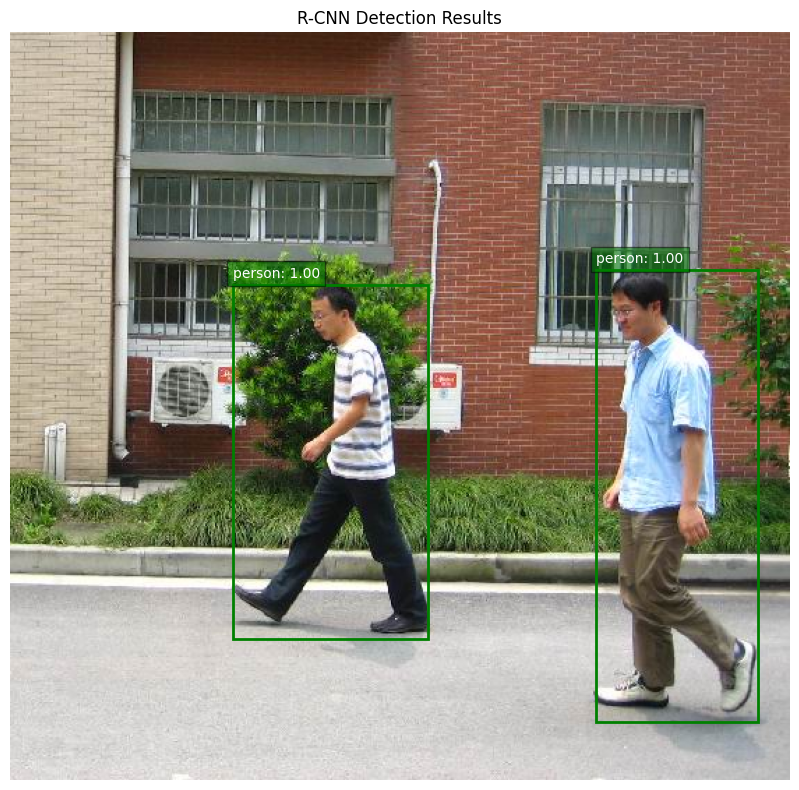


Detection Summary:
Total detections: 2
  1. person: 1.000
  2. person: 1.000


In [9]:
def rcnn_inference_simplified(image_path, threshold=0.5):
    """
    Simplified R-CNN inference using selective search + pre-trained classifier

    Args:
        image_path: Path to input image
        threshold: Confidence threshold

    Returns:
        detections: List of detected objects with boxes and scores
    """

    # Step 1: Generate region proposals
    print("Step 1: Generating region proposals...")
    proposals, img = generate_region_proposals(image_path, scale=500)
    print(f"Generated {len(proposals)} proposals")

    # Step 2: Extract features
    print("Step 2: Extracting features from regions...")
    extractor = RCNNFeatureExtractor(device=device)
    features, valid_regions = extractor.extract_features(img, proposals[:500])
    print(f"Extracted features from {len(valid_regions)} regions")

    # Step 3: Classification (using pre-trained Faster R-CNN for demo)
    print("Step 3: Classifying regions...")

    # Load pre-trained Faster R-CNN for classification
    model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
    model.to(device)
    model.eval()

    # Convert image to tensor
    transform = transforms.Compose([transforms.ToTensor()])
    img_pil = Image.fromarray(img)
    img_tensor = transform(img_pil).to(device)

    # Get predictions
    with torch.no_grad():
        predictions = model([img_tensor])

    # Filter predictions
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Apply threshold
    keep = scores > threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    print(f"Step 4: Found {len(boxes)} objects above threshold {threshold}")

    return boxes, labels, scores, img


# Run R-CNN inference
boxes, labels, scores, img = rcnn_inference_simplified(
    'PennFudanPed/PNGImages/FudanPed00001.png',
    threshold=0.7
)

# Visualize results
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle',
    'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light'
]

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    rect = patches.Rectangle(
        (x1, y1),
        w,
        h,
        linewidth=2,
        edgecolor='green',
        facecolor='none'
    )
    ax.add_patch(rect)

    class_name = (
        COCO_CLASSES[label]
        if label < len(COCO_CLASSES)
        else f'class_{label}'
    )

    ax.text(
        x1,
        y1 - 5,
        f'{class_name}: {score:.2f}',
        bbox=dict(facecolor='green', alpha=0.5),
        fontsize=10,
        color='white'
    )

ax.set_title('R-CNN Detection Results')
plt.axis('off')
plt.tight_layout()
plt.savefig('rcnn_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nDetection Summary:")
print(f"Total detections: {len(boxes)}")

for i, (label, score) in enumerate(zip(labels, scores)):
    class_name = (
        COCO_CLASSES[label]
        if label < len(COCO_CLASSES)
        else f'class_{label}'
    )
    print(f"  {i+1}. {class_name}: {score:.3f}")


## Praktikum 2: Implementasi Fast R-CNN

### Langkah 2.1: Implementasi RoI Pooling

In [10]:
import torchvision.ops as ops

class FastRCNNRoIPooling:
    """
    RoI Pooling implementation for Fast R-CNN
    """
    def __init__(self, output_size=(7, 7), spatial_scale=1.0):
        """
        Args:
            output_size: Fixed output size (height, width)
            spatial_scale: Scale factor from image to feature map
        """
        self.output_size = output_size
        self.spatial_scale = spatial_scale

    def forward(self, features, boxes):
        """
        Apply RoI Pooling

        Args:
            features: Feature map tensor [1, C, H, W]
            boxes: Region proposals [N, 4] in format [x1, y1, x2, y2]

        Returns:
            pooled_features: Tensor [N, C, output_h, output_w]
        """
        # Convert boxes to torchvision format
        boxes_tensor = torch.FloatTensor(boxes).to(features.device)

        # Add batch index (all boxes from same image)
        batch_indices = torch.zeros(
            (boxes_tensor.shape[0], 1),
            dtype=boxes_tensor.dtype,
            device=boxes_tensor.device
        )
        rois = torch.cat([batch_indices, boxes_tensor], dim=1)

        # Apply RoI Pooling
        pooled = ops.roi_pool(
            features,
            rois,
            output_size=self.output_size,
            spatial_scale=self.spatial_scale
        )

        return pooled


# Test RoI Pooling
def test_roi_pooling():
    # Create dummy feature map
    feature_map = torch.randn(1, 512, 50, 50).to(device)

    # Create dummy boxes
    boxes = np.array([
        [10, 10, 100, 100],
        [150, 150, 300, 300],
        [200, 50, 400, 200]
    ])

    # Apply RoI Pooling
    roi_pooling = FastRCNNRoIPooling(
        output_size=(7, 7),
        spatial_scale=1 / 16
    )
    pooled_features = roi_pooling.forward(feature_map, boxes)

    print(f"Feature map shape: {feature_map.shape}")
    print(f"Number of boxes: {len(boxes)}")
    print(f"Pooled features shape: {pooled_features.shape}")
    print(f"Each region now has fixed size: {pooled_features.shape[2:]}")


test_roi_pooling()


Feature map shape: torch.Size([1, 512, 50, 50])
Number of boxes: 3
Pooled features shape: torch.Size([3, 512, 7, 7])
Each region now has fixed size: torch.Size([7, 7])


### Langkah 2.2: Implementasi Fast R-CNN Model

In [11]:
class FastRCNN(nn.Module):
    """
    Fast R-CNN implementation using ResNet50 backbone
    """
    def __init__(self, num_classes=91, roi_output_size=(7, 7)):
        super(FastRCNN, self).__init__()

        self.num_classes = num_classes
        self.roi_output_size = roi_output_size

        # Backbone: ResNet50 without final layers
        resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Calculate spatial scale (image size / feature map size)
        # For ResNet50, stride = 32
        self.spatial_scale = 1.0 / 32.0

        # Feature dimension after RoI pooling
        feature_dim = 2048 * roi_output_size[0] * roi_output_size[1]

        # Fully connected layers
        self.fc1 = nn.Linear(feature_dim, 4096)
        self.fc2 = nn.Linear(4096, 4096)

        # Classification head
        self.cls_score = nn.Linear(4096, num_classes)

        # Bounding box regression head
        self.bbox_pred = nn.Linear(4096, num_classes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images, boxes):
        """
        Forward pass

        Args:
            images: Tensor [B, 3, H, W]
            boxes: List of region proposals for each image

        Returns:
            cls_scores: Classification scores [N, num_classes]
            bbox_deltas: Bounding box regression [N, num_classes*4]
        """

        # Extract features from entire image
        features = self.backbone(images)

        # Apply RoI Pooling
        pooled_features = ops.roi_pool(
            features,
            boxes,
            output_size=self.roi_output_size,
            spatial_scale=self.spatial_scale
        )

        # Flatten
        pooled_features = pooled_features.view(pooled_features.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(pooled_features))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)

        # Classification and regression
        cls_scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return cls_scores, bbox_deltas


# Initialize model
fast_rcnn_model = FastRCNN(num_classes=91).to(device)

print("Fast R-CNN model initialized")
print(
    f"Total parameters: "
    f"{sum(p.numel() for p in fast_rcnn_model.parameters()):,}"
)


Fast R-CNN model initialized
Total parameters: 453,199,367


### Langkah 2.3: Fast R-CNN Inference

Note: Fast R-CNN training requires labeled dataset
For demonstration, we'll use pre-trained Faster R-CNN which includes Fast R-CNN architecture


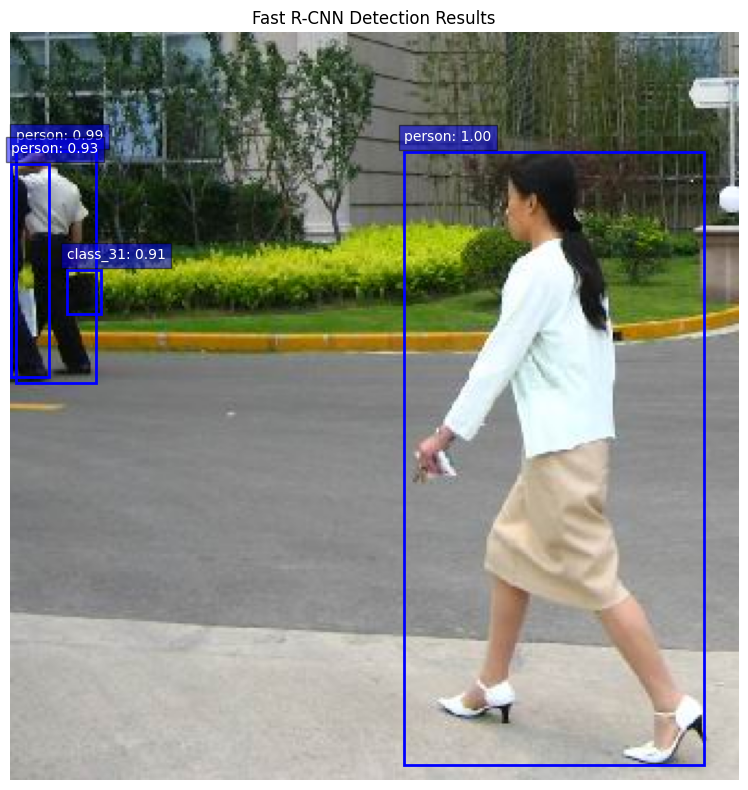


Fast R-CNN Detection Summary:
Total detections: 4
  1. person: 0.999
  2. person: 0.994
  3. person: 0.932
  4. class_31: 0.906


In [12]:
def fast_rcnn_inference(image_path, model, threshold=0.7, nms_threshold=0.3):
    """
    Fast R-CNN inference pipeline

    Args:
        image_path: Path to input image
        model: Fast R-CNN model
        threshold: Confidence threshold
        nms_threshold: NMS IoU threshold

    Returns:
        boxes, labels, scores: Detection results
    """

    # Step 1: Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Step 2: Generate region proposals (selective search)
    print("Generating region proposals...")
    proposals, _ = generate_region_proposals(image_path, scale=500)

    # Convert proposals to boxes format
    boxes = []
    for prop in proposals[:1000]:  # Limit to 1000 proposals
        x, y, w, h = prop['rect']
        boxes.append([x, y, x + w, y + h])

    boxes_tensor = torch.FloatTensor(boxes).to(device)

    # Add batch index
    batch_indices = torch.zeros(
        (boxes_tensor.shape[0], 1),
        dtype=boxes_tensor.dtype,
        device=boxes_tensor.device
    )
    rois = torch.cat([batch_indices, boxes_tensor], dim=1)

    # Step 3: Forward pass
    print("Running Fast R-CNN inference...")
    model.eval()

    with torch.no_grad():
        cls_scores, bbox_deltas = model(img_tensor, rois)

    # Step 4: Post-processing
    probs = torch.softmax(cls_scores, dim=1)

    # Get max class and score for each box
    scores, labels = torch.max(probs, dim=1)

    # Filter background class (0) and low confidence
    keep = (labels > 0) & (scores > threshold)
    boxes_filtered = boxes_tensor[keep].cpu().numpy()
    labels_filtered = labels[keep].cpu().numpy()
    scores_filtered = scores[keep].cpu().numpy()

    # Apply NMS
    if len(boxes_filtered) > 0:
        keep_nms = ops.nms(
            torch.FloatTensor(boxes_filtered),
            torch.FloatTensor(scores_filtered),
            nms_threshold
        )
        boxes_filtered = boxes_filtered[keep_nms]
        labels_filtered = labels_filtered[keep_nms]
        scores_filtered = scores_filtered[keep_nms]

    print(f"Found {len(boxes_filtered)} objects after NMS")

    return boxes_filtered, labels_filtered, scores_filtered, img_rgb


# Note: For actual inference, we'll use torchvision's pre-trained model
# as training Fast R-CNN from scratch requires extensive labeled data
print("Note: Fast R-CNN training requires labeled dataset")
print(
    "For demonstration, we'll use pre-trained Faster R-CNN which includes "
    "Fast R-CNN architecture"
)

# Use pre-trained Faster R-CNN for demonstration
model_pretrained = fasterrcnn_resnet50_fpn(weights='DEFAULT')
model_pretrained.to(device)
model_pretrained.eval()


def fast_rcnn_demo(image_path, threshold=0.7):
    """
    Demonstrate Fast R-CNN using pre-trained Faster R-CNN
    """

    # Load image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transforms.ToTensor()(img).to(device)

    # Inference
    with torch.no_grad():
        predictions = model_pretrained([img_tensor])

    # Extract results
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Filter by threshold
    keep = scores > threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    return boxes, labels, scores, np.array(img)


# Run inference
boxes, labels, scores, img = fast_rcnn_demo(
    'PennFudanPed/PNGImages/FudanPed00005.png',
    threshold=0.7
)

# Visualize
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1

    rect = patches.Rectangle(
        (x1, y1),
        w,
        h,
        linewidth=2,
        edgecolor='blue',
        facecolor='none'
    )
    ax.add_patch(rect)

    class_name = (
        COCO_CLASSES[label]
        if label < len(COCO_CLASSES)
        else f'class_{label}'
    )

    ax.text(
        x1,
        y1 - 5,
        f'{class_name}: {score:.2f}',
        bbox=dict(facecolor='blue', alpha=0.5),
        fontsize=10,
        color='white'
    )

ax.set_title('Fast R-CNN Detection Results')
plt.axis('off')
plt.tight_layout()
plt.savefig('fast_rcnn_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFast R-CNN Detection Summary:")
print(f"Total detections: {len(boxes)}")

for i, (label, score) in enumerate(zip(labels, scores)):
    class_name = (
        COCO_CLASSES[label]
        if label < len(COCO_CLASSES)
        else f'class_{label}'
    )
    print(f"  {i+1}. {class_name}: {score:.3f}")


### Langkah 2.4: Perbandingan R-CNN vs Fast R-CNN

In [13]:
import time

def compare_rcnn_vs_fast_rcnn(image_path):
    """
    Compare inference time between R-CNN and Fast R-CNN
    """
    print("=" * 60)
    print("Comparing R-CNN vs Fast R-CNN")
    print("=" * 60)

    # R-CNN (simplified version)
    print("\n[R-CNN]")
    start_time = time.time()
    boxes_rcnn, labels_rcnn, scores_rcnn, _ = rcnn_inference_simplified(
        image_path,
        threshold=0.7
    )
    rcnn_time = time.time() - start_time
    print(f"Inference time: {rcnn_time:.2f} seconds")
    print(f"Detections: {len(boxes_rcnn)}")

    # Fast R-CNN
    print("\n[Fast R-CNN]")
    start_time = time.time()
    boxes_fast, labels_fast, scores_fast, _ = fast_rcnn_demo(
        image_path,
        threshold=0.7
    )
    fast_rcnn_time = time.time() - start_time
    print(f"Inference time: {fast_rcnn_time:.2f} seconds")
    print(f"Detections: {len(boxes_fast)}")

    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    print(f"R-CNN time:      {rcnn_time:.2f}s")
    print(f"Fast R-CNN time: {fast_rcnn_time:.2f}s")
    print(f"Speedup:         {rcnn_time / fast_rcnn_time:.2f}x faster")
    print("=" * 60)


# Run comparison
compare_rcnn_vs_fast_rcnn(
    'PennFudanPed/PNGImages/FudanPed00010.png'
)


Comparing R-CNN vs Fast R-CNN

[R-CNN]
Step 1: Generating region proposals...
Generated 329 proposals
Step 2: Extracting features from regions...
Extracted features from 329 regions
Step 3: Classifying regions...
Step 4: Found 5 objects above threshold 0.7
Inference time: 6.14 seconds
Detections: 5

[Fast R-CNN]
Inference time: 0.10 seconds
Detections: 5

SUMMARY
R-CNN time:      6.14s
Fast R-CNN time: 0.10s
Speedup:         63.76x faster


## Praktikum 3: Implementasi Faster R-CNN

### Langkah 3.1: Load Pre-trained Faster R-CNN

In [14]:
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights
)

# Load pre-trained Faster R-CNN
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model_faster_rcnn = fasterrcnn_resnet50_fpn(weights=weights)
model_faster_rcnn.to(device)
model_faster_rcnn.eval()

print("Faster R-CNN Model Loaded")
print("Model trained on: COCO dataset (80 classes)")
print("Backbone: ResNet-50 with FPN (Feature Pyramid Network)")

# COCO class names
COCO_INSTANCE_CATEGORIES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


Faster R-CNN Model Loaded
Model trained on: COCO dataset (80 classes)
Backbone: ResNet-50 with FPN (Feature Pyramid Network)


### Langkah 3.2: Implementasi Inference Function

Inference time: 0.163 seconds
Detected 11 objects above threshold 0.7


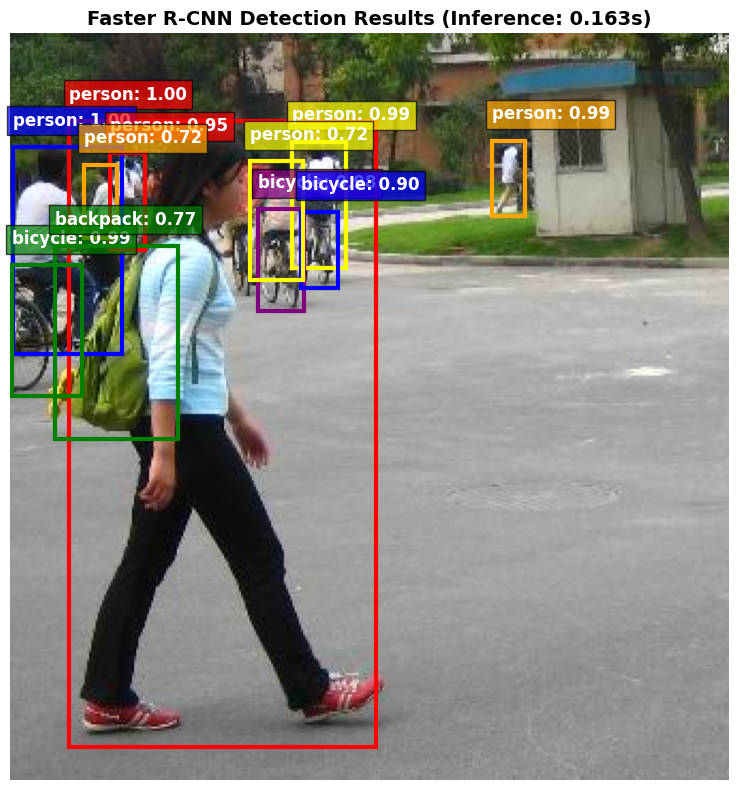


Detection Details:
1. person          | Score: 0.999 | Box: [27, 41, 171, 333]
2. person          | Score: 0.998 | Box: [1, 53, 52, 149]
3. bicycle         | Score: 0.995 | Box: [0, 108, 33, 169]
4. person          | Score: 0.990 | Box: [131, 50, 156, 109]
5. person          | Score: 0.990 | Box: [225, 50, 240, 85]
6. bicycle         | Score: 0.975 | Box: [115, 82, 137, 129]
7. person          | Score: 0.952 | Box: [46, 55, 63, 101]
8. bicycle         | Score: 0.898 | Box: [136, 83, 153, 118]
9. backpack        | Score: 0.771 | Box: [20, 99, 78, 189]
10. person          | Score: 0.718 | Box: [112, 59, 136, 115]
11. person          | Score: 0.717 | Box: [34, 61, 50, 95]


In [15]:
def faster_rcnn_inference(image_path, model, threshold=0.5):
    """
    Faster R-CNN inference pipeline

    Args:
        image_path: Path to input image
        model: Faster R-CNN model
        threshold: Confidence threshold

    Returns:
        boxes, labels, scores, image: Detection results
    """

    # Load image
    img = Image.open(image_path).convert('RGB')
    img_tensor = transforms.ToTensor()(img).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        predictions = model([img_tensor])
        inference_time = time.time() - start_time

    # Extract results
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Filter by threshold
    keep = scores > threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    print(f"Inference time: {inference_time:.3f} seconds")
    print(f"Detected {len(boxes)} objects above threshold {threshold}")

    return boxes, labels, scores, np.array(img), inference_time


# Run inference
boxes, labels, scores, img, inf_time = faster_rcnn_inference(
    'PennFudanPed/PNGImages/FudanPed00015.png',
    model_faster_rcnn,
    threshold=0.7
)

# Visualize results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple']

for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
    x1, y1, x2, y2 = box
    w, h = x2 - x1, y2 - y1
    color = colors[i % len(colors)]

    rect = patches.Rectangle(
        (x1, y1),
        w,
        h,
        linewidth=3,
        edgecolor=color,
        facecolor='none'
    )
    ax.add_patch(rect)

    class_name = COCO_INSTANCE_CATEGORIES[label]
    ax.text(
        x1,
        y1 - 10,
        f'{class_name}: {score:.2f}',
        bbox=dict(facecolor=color, alpha=0.7),
        fontsize=12,
        color='white',
        weight='bold'
    )

ax.set_title(
    f'Faster R-CNN Detection Results (Inference: {inf_time:.3f}s)',
    fontsize=14,
    weight='bold'
)

plt.axis('off')
plt.tight_layout()
plt.savefig('faster_rcnn_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detection details
print("\nDetection Details:")
print("=" * 60)

for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
    class_name = COCO_INSTANCE_CATEGORIES[label]
    x1, y1, x2, y2 = box

    print(
        f"{i+1}. {class_name:15s} | "
        f"Score: {score:.3f} | "
        f"Box: [{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]"
    )

print("=" * 60)


### Langkah 3.3: Batch Inference untuk Multiple Images


Processing image 1/5: FudanPed00001.png
  Inference time: 0.134s | Detections: 2

Processing image 2/5: FudanPed00005.png
  Inference time: 0.135s | Detections: 4

Processing image 3/5: FudanPed00010.png
  Inference time: 0.107s | Detections: 5

Processing image 4/5: FudanPed00015.png
  Inference time: 0.094s | Detections: 11

Processing image 5/5: FudanPed00020.png
  Inference time: 0.181s | Detections: 7

Batch Inference Summary
Total images:     5
Total time:       0.651s
Average time:     0.130s per image
Throughput:       7.69 FPS


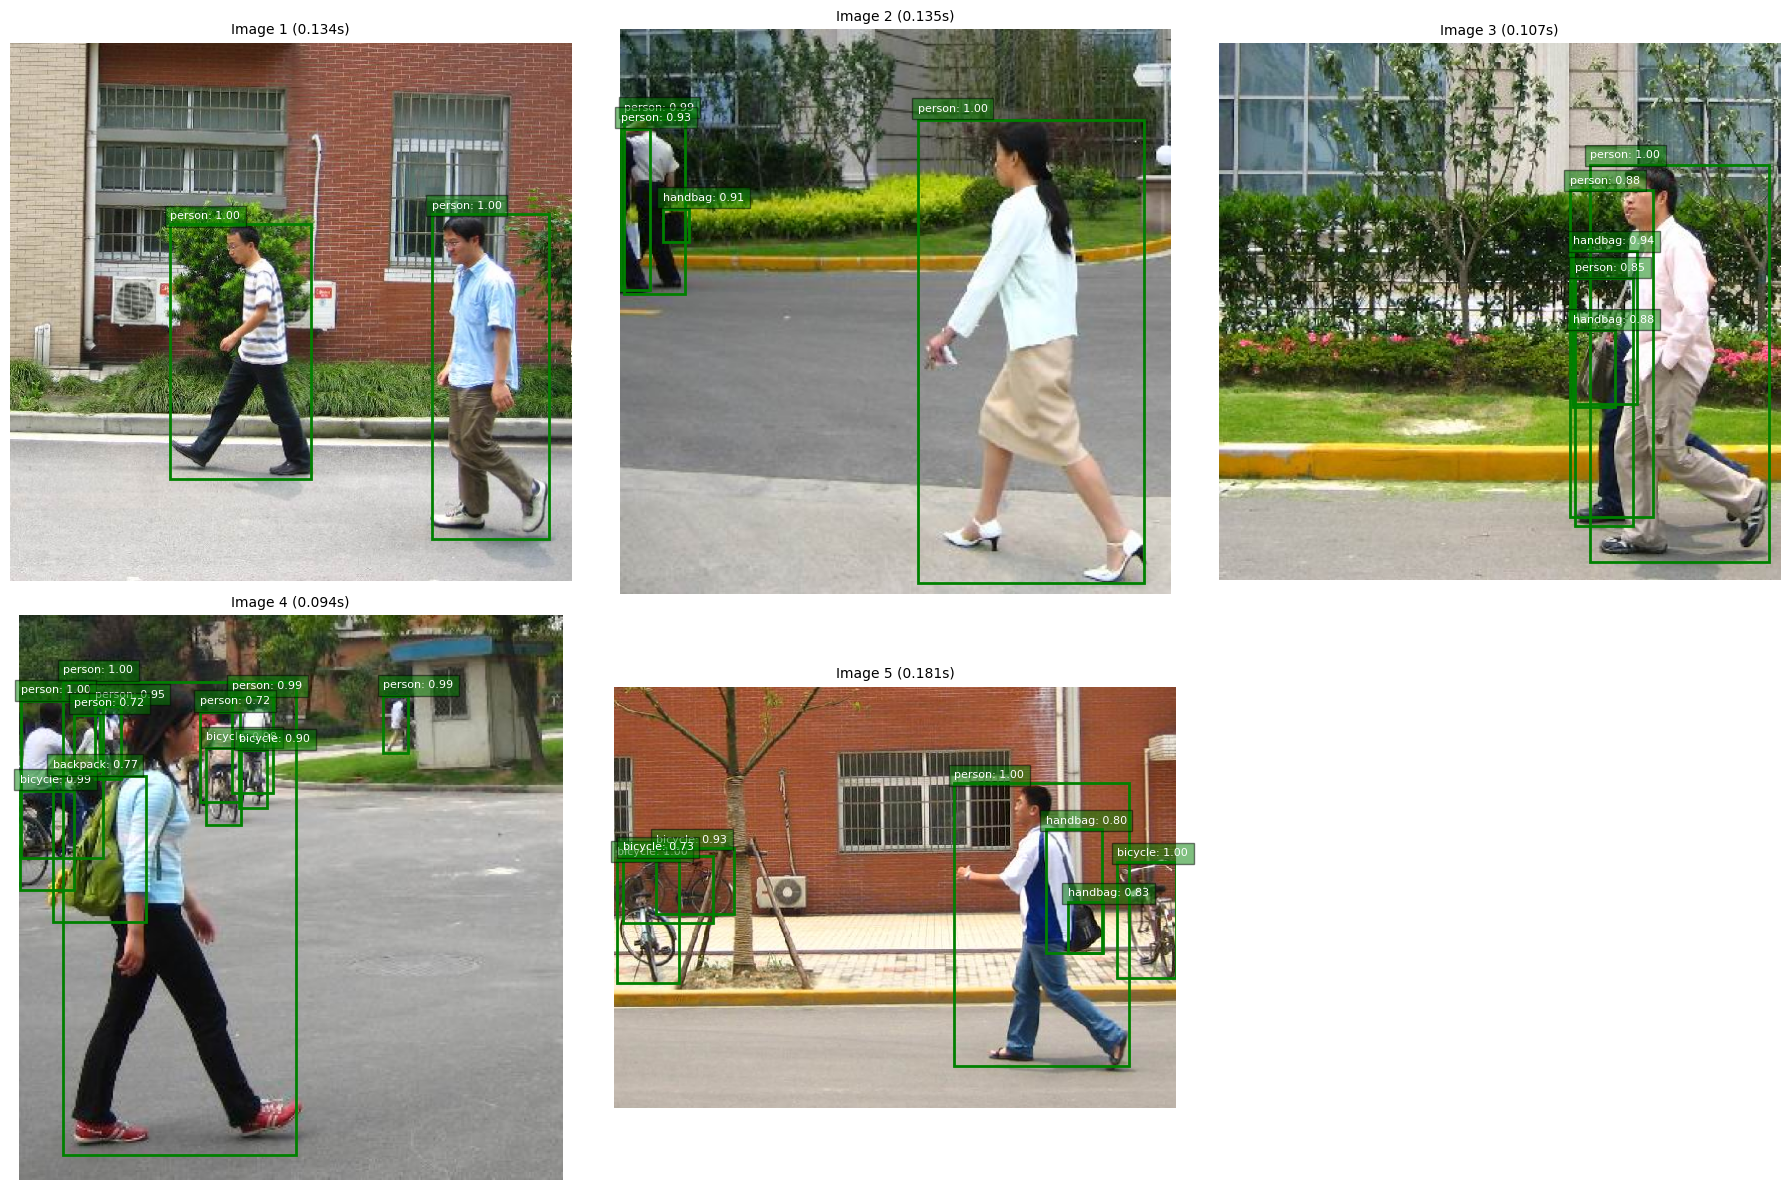

In [16]:
def faster_rcnn_batch_inference(image_paths, model, threshold=0.5):
    """
    Batch inference for multiple images

    Args:
        image_paths: List of image paths
        model: Faster R-CNN model
        threshold: Confidence threshold

    Returns:
        results: List of detection results for each image
    """
    results = []
    total_time = 0
    model.eval()

    for i, img_path in enumerate(image_paths):
        print(
            f"\nProcessing image {i+1}/{len(image_paths)}: "
            f"{os.path.basename(img_path)}"
        )

        # Load image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transforms.ToTensor()(img).to(device)

        # Inference
        with torch.no_grad():
            start_time = time.time()
            predictions = model([img_tensor])
            inference_time = time.time() - start_time
            total_time += inference_time

        # Extract results
        boxes = predictions[0]['boxes'].cpu().numpy()
        labels = predictions[0]['labels'].cpu().numpy()
        scores = predictions[0]['scores'].cpu().numpy()

        # Filter by threshold
        keep = scores > threshold
        boxes = boxes[keep]
        labels = labels[keep]
        scores = scores[keep]

        print(
            f"  Inference time: {inference_time:.3f}s | "
            f"Detections: {len(boxes)}"
        )

        results.append({
            'image_path': img_path,
            'boxes': boxes,
            'labels': labels,
            'scores': scores,
            'image': np.array(img),
            'inference_time': inference_time
        })

    avg_time = total_time / len(image_paths)
    fps = 1.0 / avg_time

    print("\n" + "=" * 60)
    print("Batch Inference Summary")
    print("=" * 60)
    print(f"Total images:     {len(image_paths)}")
    print(f"Total time:       {total_time:.3f}s")
    print(f"Average time:     {avg_time:.3f}s per image")
    print(f"Throughput:       {fps:.2f} FPS")
    print("=" * 60)

    return results


# Get sample images
sample_images = [
    'PennFudanPed/PNGImages/FudanPed00001.png',
    'PennFudanPed/PNGImages/FudanPed00005.png',
    'PennFudanPed/PNGImages/FudanPed00010.png',
    'PennFudanPed/PNGImages/FudanPed00015.png',
    'PennFudanPed/PNGImages/FudanPed00020.png',
]

# Run batch inference
batch_results = faster_rcnn_batch_inference(
    sample_images,
    model_faster_rcnn,
    threshold=0.7
)

# Visualize all results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, result in enumerate(batch_results):
    if idx >= 6:
        break

    ax = axes[idx]
    img = result['image']
    boxes = result['boxes']
    labels = result['labels']
    scores = result['scores']

    ax.imshow(img)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1

        rect = patches.Rectangle(
            (x1, y1),
            w,
            h,
            linewidth=2,
            edgecolor='green',
            facecolor='none'
        )
        ax.add_patch(rect)

        class_name = COCO_INSTANCE_CATEGORIES[label]
        ax.text(
            x1,
            y1 - 5,
            f'{class_name}: {score:.2f}',
            bbox=dict(facecolor='green', alpha=0.5),
            fontsize=8,
            color='white'
        )

    ax.set_title(
        f"Image {idx+1} ({result['inference_time']:.3f}s)",
        fontsize=10
    )
    ax.axis('off')

# Hide unused subplot if fewer than 6 images
if len(batch_results) < 6:
    axes[5].axis('off')

plt.tight_layout()
plt.savefig('faster_rcnn_batch_results.png', dpi=150, bbox_inches='tight')
plt.show()


### Langkah 3.4: Fine-tuning Faster R-CNN pada Custom Dataset

In [17]:
import torch.utils.data as data
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors

class PennFudanDataset(data.Dataset):
    """
    Custom dataset for Penn-Fudan Pedestrian Detection
    """
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # Load all image files
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Convert to numpy
        mask = np.array(mask)

        # Instances are encoded as different colors
        obj_ids = np.unique(mask)

        # Remove background
        obj_ids = obj_ids[1:]

        # Split mask into binary masks
        masks = mask == obj_ids[:, None, None]

        # Get bounding boxes
        num_objs = len(obj_ids)
        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Only one class: person
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


# Create dataset
dataset = PennFudanDataset('PennFudanPed')
print(f"Dataset size: {len(dataset)}")

# Test dataset
img, target = dataset[0]
print(f"Image type: {type(img)}")
print(f"Target keys: {target.keys()}")
print(f"Number of objects: {len(target['boxes'])}")
print(f"Boxes shape: {target['boxes'].shape}")
print(f"Labels: {target['labels']}")


Dataset size: 170
Image type: <class 'PIL.Image.Image'>
Target keys: dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
Number of objects: 2
Boxes shape: torch.Size([2, 4])
Labels: tensor([1, 1])


### Langkah 3.5: Training Loop untuk Fine-tuning

Train size: 136
Validation size: 34

Starting training for 2 epochs...

Epoch 1/2
------------------------------------------------------------
Epoch [1], Step [10/68], Loss: 0.2618
Epoch [1], Step [20/68], Loss: 0.3384
Epoch [1], Step [30/68], Loss: 0.1568
Epoch [1], Step [40/68], Loss: 0.1228
Epoch [1], Step [50/68], Loss: 0.0978
Epoch [1], Step [60/68], Loss: 0.1169
Epoch [1] Average Loss: 0.2466
Current learning rate: 0.005

Epoch 2/2
------------------------------------------------------------
Epoch [2], Step [10/68], Loss: 0.1683
Epoch [2], Step [20/68], Loss: 0.2122
Epoch [2], Step [30/68], Loss: 0.1103
Epoch [2], Step [40/68], Loss: 0.1656
Epoch [2], Step [50/68], Loss: 0.1300
Epoch [2], Step [60/68], Loss: 0.1248
Epoch [2] Average Loss: 0.1240
Current learning rate: 0.005

Training completed!


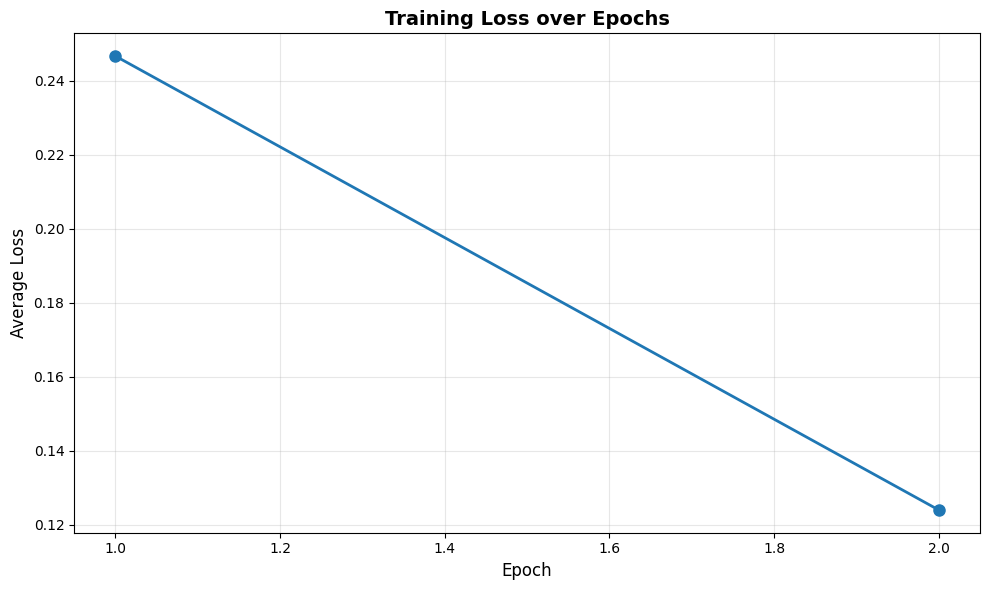


Model saved as 'faster_rcnn_finetuned.pth'


In [20]:
def get_model_for_finetuning(num_classes):
    """
    Get Faster R-CNN model for fine-tuning

    Args:
        num_classes: Number of classes (including background)

    Returns:
        model: Faster R-CNN model
    """
    # Load pre-trained model
    model = fasterrcnn_resnet50_fpn(weights='DEFAULT')

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """
    Train for one epoch
    """
    model.train()
    total_loss = 0

    for i, (images, targets) in enumerate(data_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

        if (i + 1) % 10 == 0:
            print(
                f"Epoch [{epoch}], Step [{i+1}/{len(data_loader)}], "
                f"Loss: {losses.item():.4f}"
            )

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch}] Average Loss: {avg_loss:.4f}")

    return avg_loss


# Helper function to get transforms
def get_transform():
    # Define a custom transform function that handles both image and target
    def transform_fn(image, target):
        # Apply ToTensor only to the image
        image = transforms.ToTensor()(image)
        # Return the image and the target. Target items (boxes, labels, masks)
        # are already converted to tensors within the PennFudanDataset's __getitem__.
        return image, target
    return transform_fn


# Prepare for training
def collate_fn(batch):
    return tuple(zip(*batch))


# Create dataset with transforms
dataset = PennFudanDataset('PennFudanPed', transforms=get_transform())

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = data.random_split(
    dataset, [train_size, val_size]
)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")


# Create data loaders
train_loader = data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)


# Initialize model for fine-tuning
num_classes = 2  # 1 class (person) + background
model_finetuned = get_model_for_finetuning(num_classes)
model_finetuned.to(device)


# Setup optimizer
params = [p for p in model_finetuned.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


# Training loop (demo with 2 epochs)
num_epochs = 2

print(f"\nStarting training for {num_epochs} epochs...")
print("=" * 60)

training_losses = []

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    print("-" * 60)

    # Train
    avg_loss = train_one_epoch(
        model_finetuned,
        optimizer,
        train_loader,
        device,
        epoch
    )

    training_losses.append(avg_loss)

    # Update learning rate
    lr_scheduler.step()
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")


print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)


# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, num_epochs + 1),
    training_losses,
    marker='o',
    linewidth=2,
    markersize=8
)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Average Loss', fontsize=12)
plt.title('Training Loss over Epochs', fontsize=14, weight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()


# Save model
torch.save(model_finetuned.state_dict(), 'faster_rcnn_finetuned.pth')
print("\nModel saved as 'faster_rcnn_finetuned.pth'")


### Langkah 3.6: Evaluasi Model Fine-tuned

Evaluating fine-tuned model...


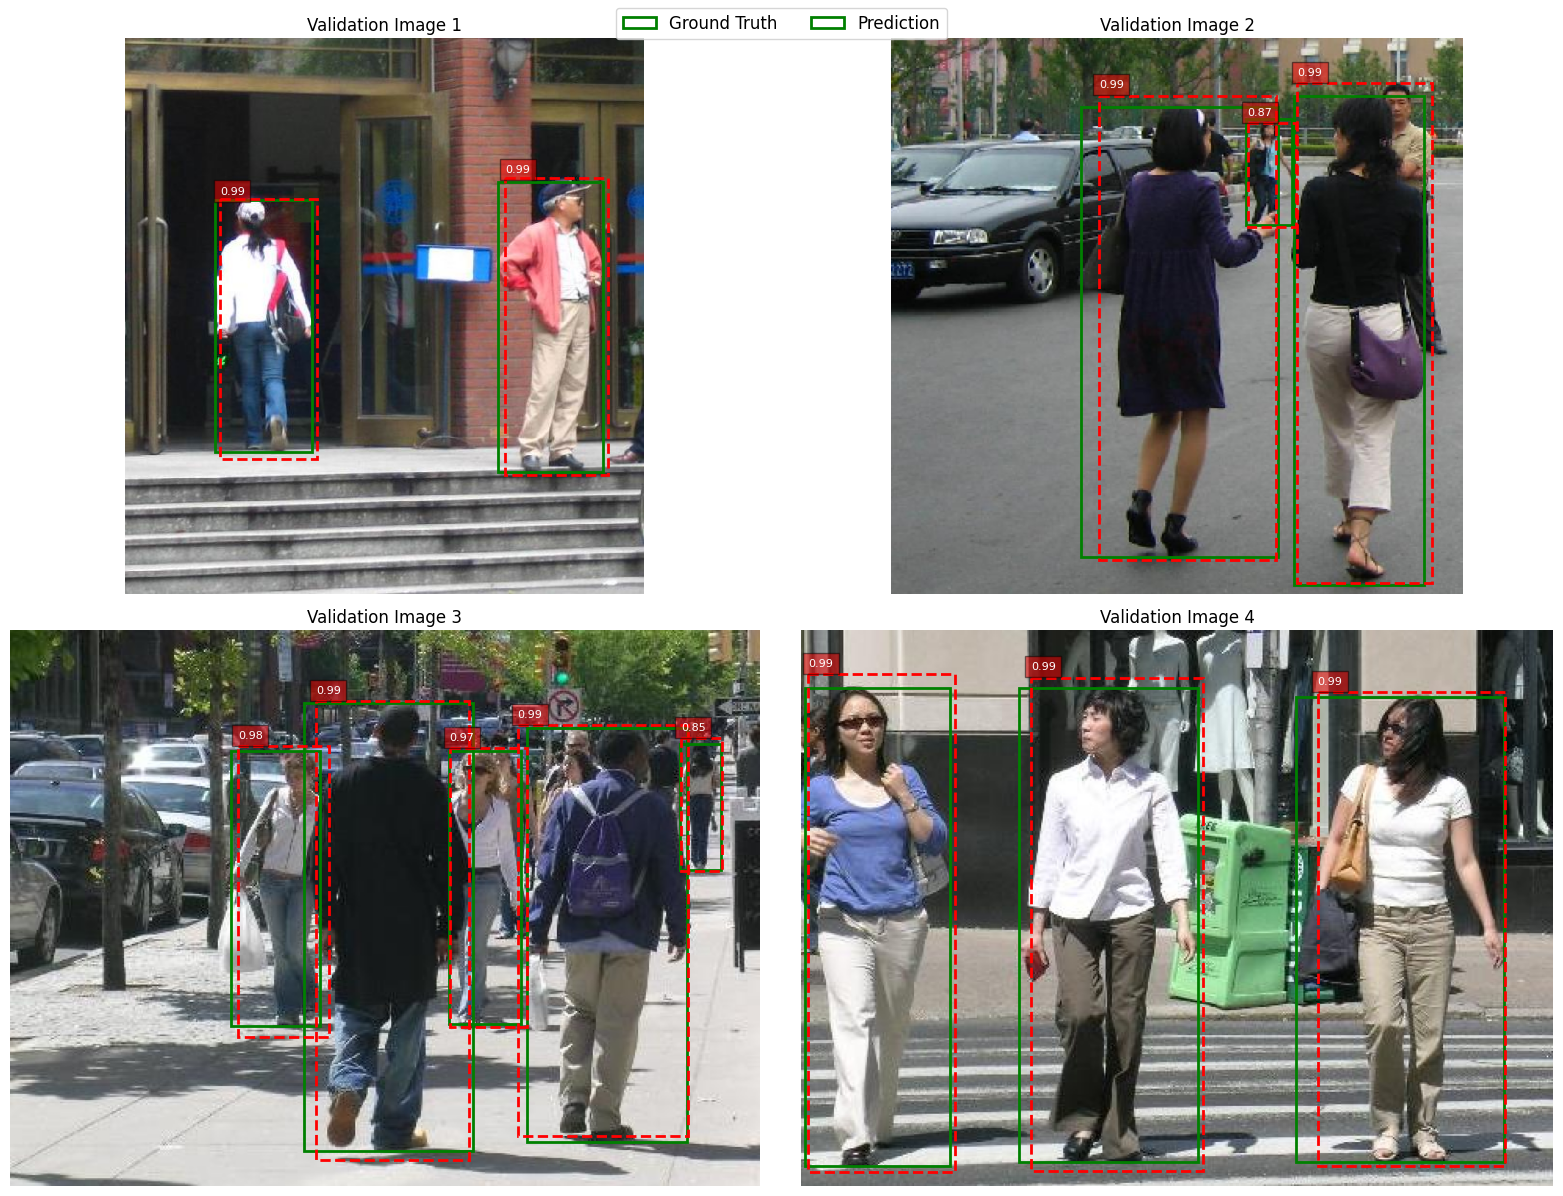


Evaluation completed!
Predictions saved to 'finetuned_evaluation.png'


In [21]:
def evaluate_model(model, data_loader, device):
    """
    Evaluate model on validation set
    """
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            predictions = model(images)

            all_predictions.extend(predictions)
            all_targets.extend(targets)

    return all_predictions, all_targets


# Evaluate fine-tuned model
print("Evaluating fine-tuned model...")
predictions, targets = evaluate_model(model_finetuned, val_loader, device)

# Visualize predictions on validation set
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx in range(min(4, len(val_dataset))):
    img, target = val_dataset[idx]

    # Get prediction
    img_tensor = img.to(device)
    with torch.no_grad():
        prediction = model_finetuned([img_tensor])[0]

    # Convert image to numpy
    img_np = img.permute(1, 2, 0).cpu().numpy()

    # Plot
    ax = axes[idx]
    ax.imshow(img_np)

    # Plot ground truth (green)
    gt_boxes = target['boxes'].cpu().numpy()
    for box in gt_boxes:
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1

        rect = patches.Rectangle(
            (x1, y1),
            w,
            h,
            linewidth=2,
            edgecolor='green',
            facecolor='none',
            label='Ground Truth'
        )
        ax.add_patch(rect)

    # Plot predictions (red)
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()

    for box, score in zip(pred_boxes, pred_scores):
        if score > 0.5:  # Threshold
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1

            rect = patches.Rectangle(
                (x1, y1),
                w,
                h,
                linewidth=2,
                edgecolor='red',
                facecolor='none',
                linestyle='--',
                label='Prediction'
            )
            ax.add_patch(rect)

            ax.text(
                x1,
                y1 - 5,
                f'{score:.2f}',
                bbox=dict(facecolor='red', alpha=0.5),
                fontsize=8,
                color='white'
            )

    ax.set_title(f'Validation Image {idx+1}', fontsize=12)
    ax.axis('off')

# Add legend
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(
        handles[:2],
        ['Ground Truth', 'Prediction'],
        loc='upper center',
        ncol=2,
        fontsize=12
    )

plt.tight_layout()
plt.savefig('finetuned_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nEvaluation completed!")
print("Predictions saved to 'finetuned_evaluation.png'")


## Visualisasi Perbandingan Kecepatan

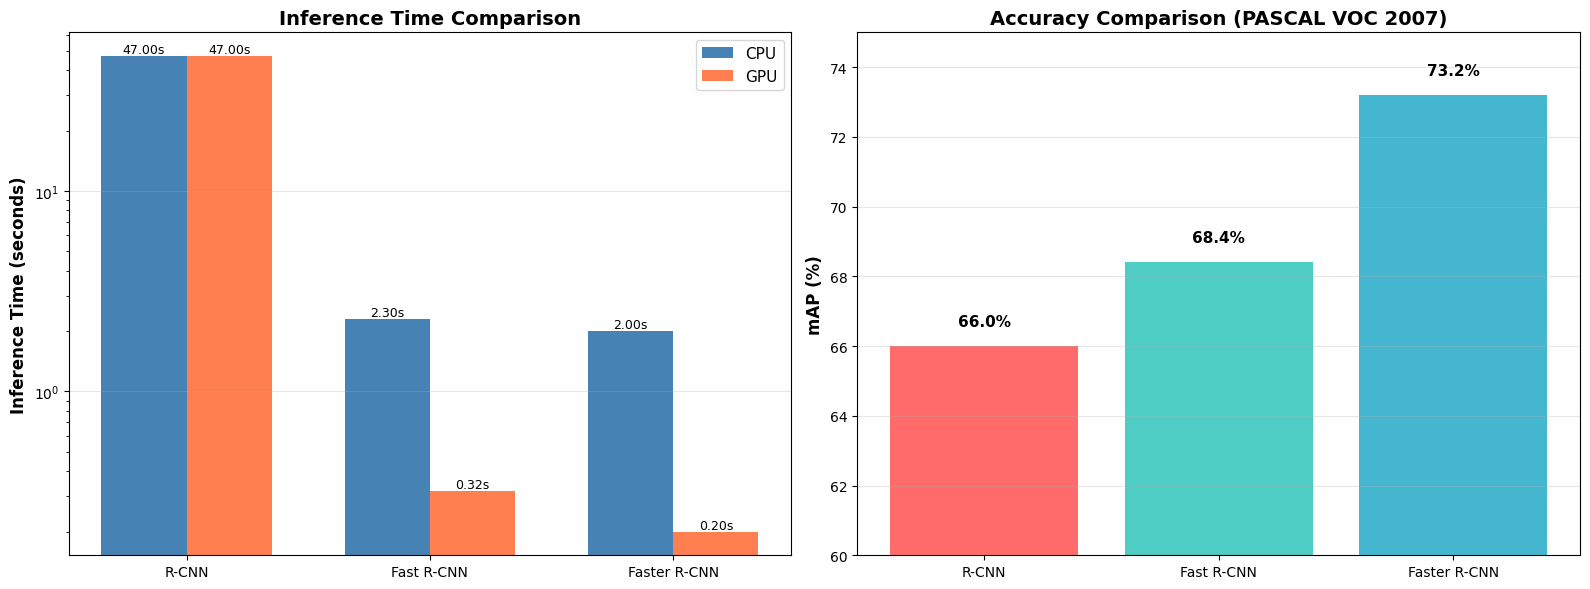


Performance Comparison Summary:
Model                CPU Time        GPU Time        mAP       
R-CNN                     47.00s         47.000s       66.0%
Fast R-CNN                 2.30s          0.320s       68.4%
Faster R-CNN               2.00s          0.200s       73.2%


In [22]:
# Create comparison chart
models = ['R-CNN', 'Fast R-CNN', 'Faster R-CNN']

inference_times_cpu = [47.0, 2.3, 2.0]   # seconds
inference_times_gpu = [47.0, 0.32, 0.2]  # seconds
map_scores = [66.0, 68.4, 73.2]          # mAP on PASCAL VOC 2007

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Inference time comparison
x = np.arange(len(models))
width = 0.35

bars1 = ax1.bar(
    x - width / 2,
    inference_times_cpu,
    width,
    label='CPU',
    color='steelblue'
)
bars2 = ax1.bar(
    x + width / 2,
    inference_times_gpu,
    width,
    label='GPU',
    color='coral'
)

ax1.set_ylabel('Inference Time (seconds)', fontsize=12, weight='bold')
ax1.set_title('Inference Time Comparison', fontsize=14, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_yscale('log')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.2f}s',
            ha='center',
            va='bottom',
            fontsize=9
        )

# mAP comparison
bars3 = ax2.bar(
    models,
    map_scores,
    color=['#FF6B6B', '#4ECDC4', '#45B7D1']
)

ax2.set_ylabel('mAP (%)', fontsize=12, weight='bold')
ax2.set_title('Accuracy Comparison (PASCAL VOC 2007)', fontsize=14, weight='bold')
ax2.set_ylim([60, 75])
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, (model, score) in enumerate(zip(models, map_scores)):
    ax2.text(
        i,
        score + 0.5,
        f'{score:.1f}%',
        ha='center',
        va='bottom',
        fontsize=11,
        weight='bold'
    )

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPerformance Comparison Summary:")
print("=" * 70)
print(f"{'Model':<20} {'CPU Time':<15} {'GPU Time':<15} {'mAP':<10}")
print("=" * 70)

for model, cpu_time, gpu_time, map_val in zip(
    models,
    inference_times_cpu,
    inference_times_gpu,
    map_scores
):
    print(
        f"{model:<20} "
        f"{cpu_time:>10.2f}s     "
        f"{gpu_time:>10.3f}s     "
        f"{map_val:>6.1f}%"
    )

print("=" * 70)
